# Part 0: Motivation

Although there have been many [studies](https://health.gov/healthypeople/objectives-and-data/leading-health-indicators) about how various economic and social predictors can be used to predict health indicators, we were curious to explore the relationship between this predictability and health indicators by age. In this notebook, we explore several correlations in our dataset between health and economic welfare. Additionally, we utilize several predictive models in order to compare the casual relationshiop in economy and society to health for different age segments of the population. We analyze the predictability of health in infants, youth, and adults for a variety of regions in the world and globally. Then, further regression models are used in order to extract feature importance and analyze exactly which social and economic predictors correlate most strongly with health outcomes. Overall, we answer the question as to how we can predict various health indicators and which age groups as easiest to predict. 

# Part 1: Data Cleaning and Data Interpolation

For this section, we focus on addressing the large number of null entries that appear in the data, especially for earlier years. We address by implementing mean-based imputation.

In [1]:
!pip install sqlalchemy==1.4.46
!pip install pandasql
!pip install -U kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Imports that we used throughout the project.

In [2]:
import pandas as pd
import pandasql as ps
from sklearn.linear_model import LinearRegression
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from pandasql import sqldf

We used one of the recommended datasets ("Health Nutrition and Population"), available [here](https://www.kaggle.com/theworldbank/health-nutrition-and-population-statistics) on Kaggle.

In [3]:
data = pd.read_csv("data.csv", delimiter=',')

**Cleans the data of null values and indicators with extremely sparse data.**

In [4]:
# Drop null column
data.drop(columns=['Unnamed: 60'], inplace=True)
# Drop columns that are highly prevalent to NaN valus
data.drop(columns=['2015', '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979'], inplace=True)
# Drop rows where all of the numerical data is missing
data = data.dropna(subset=data.columns.difference(['Indicator Name', 'Indicator Code', 'Country Code', 'Country Name']), axis = 0, how = 'all')

In [5]:
data.head(100)

,Country Name,Country Code,Indicator Name,Indicator Code,1980,1981,1982,1983,1984,1985,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
2,Arab World,ARB,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,98.739002,95.241251,91.791192,88.001177,84.207256,80.359323,...,50.732590,50.329135,4.999985e+01,49.887046,49.781207,49.672975,49.536047,4.938374e+01,48.796558,48.196418
9,Arab World,ARB,Age dependency ratio (% of working-age populat...,SP.POP.DPND,91.686776,91.484454,91.116723,90.628630,90.087551,89.520037,...,67.033365,65.786728,6.463007e+01,63.602627,62.738022,62.053505,61.794943,6.168190e+01,61.678686,61.719792
10,Arab World,ARB,"Age dependency ratio, old",SP.POP.DPND.OL,6.951620,6.929729,6.900127,6.866216,6.831922,6.801077,...,6.869148,6.821022,6.765206e+00,6.712015,6.672599,6.653749,6.678820,6.715494e+00,6.767541,6.840458
11,Arab World,ARB,"Age dependency ratio, young",SP.POP.DPND.YG,84.080553,83.880012,83.528488,83.069460,82.564146,82.030992,...,58.654147,57.359235,5.616857e+01,55.123404,54.255968,53.578642,53.318234,5.320907e+01,53.205356,53.228309
65,Arab World,ARB,Antiretroviral therapy coverage (% of people l...,SH.HIV.ARTC.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,1.681857,2.914425,3.958723e+00,5.709145,7.360087,8.827443,10.179933,1.192173e+01,14.094578,16.561200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,Arab World,ARB,"Mortality rate, neonatal (per 1,000 live births)",SH.DYN.NMRT,NaN,NaN,NaN,NaN,NaN,NaN,...,22.769319,22.247875,2.166030e+01,21.067736,20.472266,19.887504,19.355109,1.884846e+01,18.388787,17.955758
191,Arab World,ARB,"Mortality rate, under-5 (per 1,000)",SH.DYN.MORT,131.947508,124.517742,117.056233,112.787457,105.956547,99.728881,...,51.642075,49.908453,4.817509e+01,46.389049,44.672468,42.994305,41.515848,4.019674e+01,38.964340,37.789320
192,Arab World,ARB,"Mortality rate, under-5, female (per 1,000)",SH.DYN.MORT.FE,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,40.064303,NaN,NaN,NaN,NaN
193,Arab World,ARB,"Mortality rate, under-5, male (per 1,000)",SH.DYN.MORT.MA,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,45.805552,NaN,NaN,NaN,NaN


In [6]:
missing_vars = data.columns[data.isna().any()].tolist()
print(missing_vars)

['1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014']


**Fill missing data with the mean based imputation**

In [7]:
df = data.apply(lambda row: row.fillna(row[data.columns.difference(['Indicator Name', 'Indicator Code', 'Country Code', 'Country Name'])].mean()), axis=1).dropna()

In [8]:
df.head(100)

,Country Name,Country Code,Indicator Name,Indicator Code,1980,1981,1982,1983,1984,1985,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
2,Arab World,ARB,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,98.739002,95.241251,91.791192,88.001177,84.207256,80.359323,...,50.732590,50.329135,4.999985e+01,49.887046,49.781207,49.672975,49.536047,4.938374e+01,48.796558,48.196418
9,Arab World,ARB,Age dependency ratio (% of working-age populat...,SP.POP.DPND,91.686776,91.484454,91.116723,90.628630,90.087551,89.520037,...,67.033365,65.786728,6.463007e+01,63.602627,62.738022,62.053505,61.794943,6.168190e+01,61.678686,61.719792
10,Arab World,ARB,"Age dependency ratio, old",SP.POP.DPND.OL,6.951620,6.929729,6.900127,6.866216,6.831922,6.801077,...,6.869148,6.821022,6.765206e+00,6.712015,6.672599,6.653749,6.678820,6.715494e+00,6.767541,6.840458
11,Arab World,ARB,"Age dependency ratio, young",SP.POP.DPND.YG,84.080553,83.880012,83.528488,83.069460,82.564146,82.030992,...,58.654147,57.359235,5.616857e+01,55.123404,54.255968,53.578642,53.318234,5.320907e+01,53.205356,53.228309
65,Arab World,ARB,Antiretroviral therapy coverage (% of people l...,SH.HIV.ARTC.ZS,5.705189,5.705189,5.705189,5.705189,5.705189,5.705189,...,1.681857,2.914425,3.958723e+00,5.709145,7.360087,8.827443,10.179933,1.192173e+01,14.094578,16.561200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,Arab World,ARB,"Mortality rate, neonatal (per 1,000 live births)",SH.DYN.NMRT,24.274727,24.274727,24.274727,24.274727,24.274727,24.274727,...,22.769319,22.247875,2.166030e+01,21.067736,20.472266,19.887504,19.355109,1.884846e+01,18.388787,17.955758
191,Arab World,ARB,"Mortality rate, under-5 (per 1,000)",SH.DYN.MORT,131.947508,124.517742,117.056233,112.787457,105.956547,99.728881,...,51.642075,49.908453,4.817509e+01,46.389049,44.672468,42.994305,41.515848,4.019674e+01,38.964340,37.789320
192,Arab World,ARB,"Mortality rate, under-5, female (per 1,000)",SH.DYN.MORT.FE,57.770498,57.770498,57.770498,57.770498,57.770498,57.770498,...,57.770498,57.770498,5.777050e+01,57.770498,57.770498,40.064303,57.770498,5.777050e+01,57.770498,57.770498
193,Arab World,ARB,"Mortality rate, under-5, male (per 1,000)",SH.DYN.MORT.MA,64.352028,64.352028,64.352028,64.352028,64.352028,64.352028,...,64.352028,64.352028,6.435203e+01,64.352028,64.352028,45.805552,64.352028,6.435203e+01,64.352028,64.352028


In [9]:
df1 = df
df = df.loc[df['Country Code'].isin(["EUU"])]
df.drop(columns=['Country Name', 'Country Code'], inplace=True)

<ipython-input-9-afac849b6adb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['Country Name', 'Country Code'], inplace=True)


In [10]:
# Print a sorted list of unique values in the 'Indicator Name' column of the dataframe
# First, select the 'Indicator Name' column of the dataframe using df['Indicator Name']
# Use set() to get a unique set of values in the 'Indicator Name' column
# Use list() to convert the set back to a list
# Use sorted() to sort the list of values alphabetically
# Use the * operator to unpack the list of values and pass each value as a separate argument to the print function
# Use sep="\n" to specify that each value should be printed on a separate line

print(*sorted(list(set((df['Indicator Name'])))), sep="\n")

Adolescent fertility rate (births per 1,000 women ages 15-19)
Age dependency ratio (% of working-age population)
Age dependency ratio, old
Age dependency ratio, young
Birth rate, crude (per 1,000 people)
Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions (% of total)
Cause of death, by injury (% of total)
Cause of death, by non-communicable diseases (% of total)
Completeness of birth registration (%)
Completeness of death registration with cause-of-death information (%)
Death rate, crude (per 1,000 people)
External resources for health (% of total expenditure on health)
Female population 00-04
Female population 05-09
Female population 10-14
Female population 15-19
Female population 20-24
Female population 25-29
Female population 30-34
Female population 35-39
Female population 40-44
Female population 45-49
Female population 50-54
Female population 55-59
Female population 60-64
Female population 65-69
Female population 70-74
Female population 75-79
F

# Part 2: EDA

The selection of **predictors for health** can be a complex and multifaceted process, as there are numerous factors that can impact health outcomes. In the list provided, we have chosen a range of variables that we believe are likely to have significant associations with health.

**Health Predictors:**

*   Fertility rate, total (births per woman)
*   Population growth (annual %)
*   Adolescent fertility rate (births per 1,000 women ages 15-19)
*   Birth rate, crude (per 1,000 people)
*   Health expenditure, per capita, PPPHealth expenditure, private (% of GDP)
*   Health expenditure, private etc.
*   Health expenditure, public etc.
*   Health expenditure, public
*   Immunization, DPT (% of children ages 12-23 months)
*   Immunization, HepB3 (% of one-year-old children)
*   Immunization, Hib3 (% of children ages 12-23 months)
*   Immunization, Pol3 (% of one-year-old children)
*   Immunization, measles (% of children ages 12-23 months)
*   Improved sanitation facilities (% of population with access)
*   Improved sanitation facilities, rural (% of rural population with access)
*   Improved sanitation facilities, urban (% of urban population with access)
*   Improved water source (% of population with access)
*   Improved water source, rural (% of rural population with access)
*   Improved water source, urban (% of urban population with access)
*   Life expectancy at birth, total (years)
*   Literacy rate, adult total (% of people ages 15 and above)
*   Literacy rate, youth total (% of people ages 15-24)
*   Out-of-pocket health expenditure (% of private expenditure on health)
*   Out-of-pocket health expenditure (% of total expenditure on health)
*   People practicing open defecation, rural (% of rural population)
*   People practicing open defecation, urban (% of urban population)
*   Risk of catastrophic expenditure for surgical care (% of people at risk)
*   Risk of impoverishing expenditure for surgical care (% of people at risk)

Firstly, we have included several indicators related to population growth and fertility rates. These factors can be important determinants of health outcomes, as they can influence the availability of resources and services, as well as the overall health of mothers and infants. Additionally, we have included variables related to adolescent fertility rates and crude birth rates, which can also have implications for maternal and child health.

We have also included several variables related to health expenditures, including measures of private and public spending on health. These indicators can provide insight into the availability and accessibility of healthcare services, which can be critical factors in determining health outcomes. Moreover, we have included measures of out-of-pocket health expenditures, which can highlight the financial burden that healthcare costs may place on individuals and families.

In terms of specific health indicators, we have included a range of variables related to immunization coverage, sanitation, and access to clean water. These factors are all critical determinants of health, as they can impact the prevalence and spread of infectious diseases. Finally, we have included measures of life expectancy and literacy rates, which can provide important insights into the overall health and well-being of a population.

We also picked a handful of indicators for three age groups—infants, children, and adulthood—by reading through all of the indicators provided in the data set and picking ones that were relevant to a specific age group.

**Infancy Health Indicators**

*   Mortality rate, infant (per 1,000 live births) (SP.DYN.IMRT.IN
*   Mortality rate, infant, female (per 1,000 live births) (SP.DYN.IMRT.FE.IN)
*   Mortality rate, infant, male (per 1,000 live births) (SP.DYN.IMRT.MA.IN)
*   Mortality rate, neonatal (per 1,000 live births) (SH.DYN.NMRT)
*   Prevalence of anemia among children (% of children under 5) (SH.ANM.CHLD.ZS)
*   Immunization, BCG (% of one-year-old children) (SH.IMM.IDPT)
*   Immunization, DPT (% of children ages 12-23 months) (SH.IMM.HEPB)

**Youth Health Indicators**

*   Mortality rate, under-5 (per 1,000) (SH.DYN.MORT)
*   Mortality rate, under-5, female (per 1,000) (SH.DYN.MORT.FE)
*   Mortality rate, under-5, male (per 1,000) (SH.DYN.MORT.MA)
*   Prevalence of anemia among children (% of children under 5)
*   Children (0-14) living with HIV (SH.HIV.0014)
*   Prevalence of overweight (% of children under 5) (SH.STA.OWGH.ZS)

**Adult Health Indicators**

*   Mortality caused by road traffic injury (per 100,000 people) (SH.STA.TRAF.P5)
*   Maternal mortality ratio (modeled estimate, per 100,000 live births) (SH.STA.TRAF.P5)
*   Mortality rate, adult, female (per 1,000 female adults) (SP.DYN.AMRT.FE)
*   Mortality rate, adult, male (per 1,000 male adults) (SP.DYN.AMRT.MA)
*   Prevalence of anemia among non-pregnant women (% of women ages 15-49) (SH.ANM.NPRG.ZS)
*   Prevalence of anemia among pregnant women (%) (SH.PRG.ANEM)
*   Prevalence of anemia among women of reproductive age (% of women ages 15-49) (SH.ANM.ALLW.ZS)
*   Adults (ages 15+) newly infected with HIV (SH.HIV.INCD)


**Below are these predictors represented as Python lists for use in the notebook.**

In [11]:
predictors = [
    "Fertility rate, total (births per woman)",
    "Population growth (annual %)",
    "Adolescent fertility rate (births per 1,000 women ages 15-19)",
    "Birth rate, crude (per 1,000 people)",
    "Health expenditure, per capita, PPP",
    "Health expenditure, private (% of GDP)",
    "Health expenditure, private etc.",
    "Health expenditure, public etc.",
    "Health expenditure, public",
    "Immunization, DPT (% of children ages 12-23 months)",
    "Immunization, HepB3 (% of one-year-old children)",
    "Immunization, Hib3 (% of children ages 12-23 months)",
    "Immunization, Pol3 (% of one-year-old children)",
    "Immunization, measles (% of children ages 12-23 months)",
    "Improved sanitation facilities (% of population with access)",
    "Improved sanitation facilities, rural (% of rural population with access)",
    "Improved sanitation facilities, urban (% of urban population with access)",
    "Improved water source (% of population with access)",
    "Improved water source, rural (% of rural population with access)",
    "Improved water source, urban (% of urban population with access)",
    "Life expectancy at birth, total (years)",
    "Literacy rate, adult total (% of people ages 15 and above)",
    "Literacy rate, youth total (% of people ages 15-24)",
    "Out-of-pocket health expenditure (% of private expenditure on health)",
    "Out-of-pocket health expenditure (% of total expenditure on health)",
    "People practicing open defecation, rural (% of rural population)",
    "People practicing open defecation, urban (% of urban population)",
    "Risk of catastrophic expenditure for surgical care (% of people at risk)",
    "Risk of impoverishing expenditure for surgical care (% of people at risk)"
]


infancy_indicators = [
    "Mortality rate, infant (per 1,000 live births)",
    "Mortality rate, infant, female (per 1,000 live births)",
    "Mortality rate, infant, male (per 1,000 live births)",
    "Mortality rate, neonatal (per 1,000 live births)",
    "Prevalence of anemia among children (% of children under 5)",
    "Immunization, BCG (% of one-year-old children)",
    "Immunization, DPT (% of children ages 12-23 months)"
]

youth_indicators = [
    "Mortality rate, under-5 (per 1,000)",
    "Mortality rate, under-5, female (per 1,000)",
    "Mortality rate, under-5, male (per 1,000)",
    "Prevalence of anemia among children (% of children under 5)",
    "Children (0-14) living with HIV",
    "Prevalence of overweight (% of children under 5)"
]

adult_indicators = [
    "Mortality caused by road traffic injury (per 100,000 people)",
    "Maternal mortality ratio (modeled estimate, per 100,000 live births)",
    "Mortality rate, adult, female (per 1,000 female adults)",
    "Mortality rate, adult, male (per 1,000 male adults)",
    "Prevalence of anemia among non-pregnant women (% of women ages 15-49)",
    "Prevalence of anemia among pregnant women (%)",
    "Prevalence of anemia among women of reproductive age (% of women ages 15-49)",
    "Adults (ages 15+) newly infected with HIV"
]


## 2.1: Preparing data for country's economy classifcation analysis

According to the [World Bank](https://blogs.worldbank.org/opendata/new-world-bank-country-classifications-income-level-2022-2023), a country's economy can be classified as one of the following categories based on the GDP per capita:



> H = high income: more than 12695

> UM = upper-middle income: between 4096-12695

> LM = lower-middle income: between 1046-4095

> L = low income: less than 1045

We downloaded a data set from [World Bank](https://data.worldbank.org/indicator/NY.GDP.MKTP.CD) that contains the GDP in current US dollars for all of the countries that are in our original Kaggle dataset.

In [12]:
gdp_df = pd.read_csv("/content/gdp.csv")

Given that the economic classification of countries has not changed much over years, we chose to base our economic classification off of the GDP of the countries in the year 2015.

In [13]:
# Only select columns relevant for joining the datasets. 
gdp_2015_df = gdp_df[['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code', '2015']]
gdp_2015_series = gdp_2015_df['2015']

We first attemped to get an understanding of the distribution of the GDPs using quantiles.

In [14]:
q1 = gdp_2015_series.quantile(0.25)
q2 = gdp_2015_series.quantile(0.50)
q3 = gdp_2015_series.quantile(0.75)

print('25th percentile: ', q1)
print('50th percentile: ', q2)
print('75th percentile: ', q3)

25th percentile:  8589120141.744617
50th percentile:  49667953134.8762
75th percentile:  502084531612.708


We also graphed the GDPs using a boxplot and a distribution plot, as shown below.

/usr/local/lib/python3.9/dist-packages/seaborn/_oldcore.py:1599: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


<Axes: xlabel='2015'>

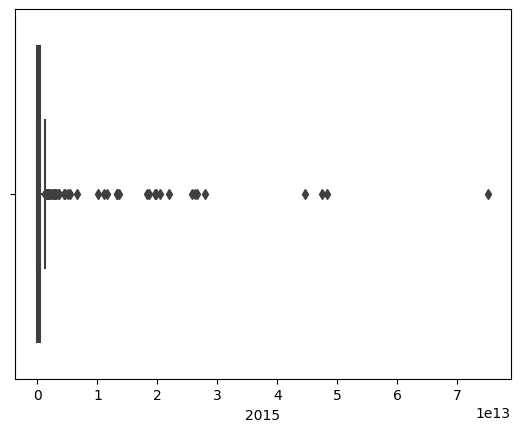

In [15]:
sns.boxplot(x=gdp_2015_series, orient='v')

<ipython-input-16-9f9878c413f9>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(gdp_2015_series)


<Axes: xlabel='2015', ylabel='Density'>

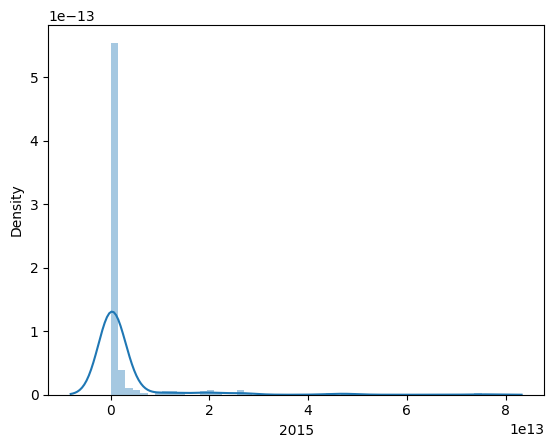

In [16]:
sns.distplot(gdp_2015_series)

The above plots clearly showed that the GDP data was very skewed.

After realizing that failing to take into account the population of the country was leading to disproportionate results, we downloaded another dataset from [World Bank](https://data.worldbank.org/indicator/NY.GDP.PCAP.CD). This time, the dataset contained the GDP **per capita** in current US dollars for all of the countries that are in our original Kaggle dataset.

In [17]:
gdp_cap_df = pd.read_csv("/content/gdp_cap.csv")

In [18]:
gdp_cap_2015_df = gdp_cap_df[['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code', '2015']]

In [19]:
# extract the '2015' column from the GDP per capita DataFrame and assign it to a Series
gdp_cap_2015_series = gdp_cap_2015_df['2015']

# calculate the 25th, 50th, and 75th percentiles of the GDP per capita data for 2015
q1 = gdp_cap_2015_series.quantile(0.25)
q2 = gdp_cap_2015_series.quantile(0.50)
q3 = gdp_cap_2015_series.quantile(0.75)

# print the results
print('25th percentile: ', q1)
print('50th percentile: ', q2)
print('75th percentile: ', q3)

25th percentile:  2097.3311788744427
50th percentile:  6192.5624293745805
75th percentile:  18210.35945634525


Plotting the GDP per capita data below using a boxplot showed different results than from before.

/usr/local/lib/python3.9/dist-packages/seaborn/_oldcore.py:1599: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


Text(0.5, 0, 'GDP per Capita (USD)')

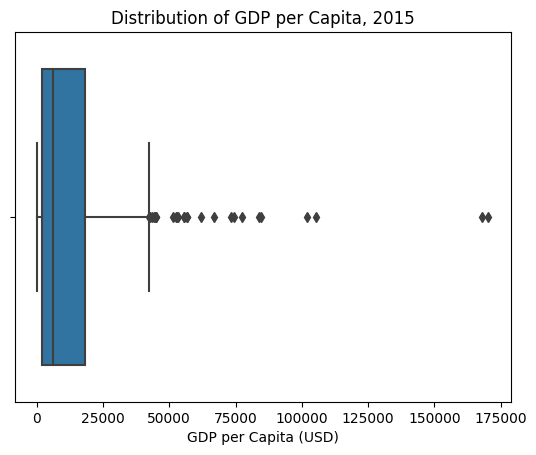

In [20]:
sns.boxplot(x=gdp_cap_2015_series, orient='v')
plt.title("Distribution of GDP per Capita, 2015")
plt.xlabel("GDP per Capita (USD)")

In [21]:
# Select high-income countries with a GDP per capita of 12,095 or higher
h_countries_df = gdp_cap_df[gdp_cap_df['2015'] >= 12095]

# Select upper-middle-income countries with a GDP per capita between 4,096 and 12,094
um_countries_df = gdp_cap_df[(gdp_cap_df['2015'] >= 4096) & (gdp_cap_df['2015'] < 12095)]

# Select lower-middle-income countries with a GDP per capita between 1,046 and 4,095
lm_countries_df = gdp_cap_df[(gdp_cap_df['2015'] >= 1046) & (gdp_cap_df['2015'] <= 4096)]

# Select low-income countries with a GDP per capita of 1,045 or lower
l_countries_df = gdp_cap_df[gdp_cap_df['2015'] <= 1045]

In [22]:
# Counting the number of countries in each GDP category
num_h = h_countries_df.shape[0]
num_um = um_countries_df.shape[0]
num_lm = lm_countries_df.shape[0]
num_l = l_countries_df.shape[0]

# Printing the number of countries in each GDP category
print("Number of high-income countries: ", num_h)
print("Number of upper-middle-income countries: ", num_um)
print("Number of lower-middle-income countries: ", num_lm)
print("Number of low-income countries: ", num_l)

Number of high-income countries:  85
Number of upper-middle-income countries:  67
Number of lower-middle-income countries:  76
Number of low-income countries:  30


In [23]:
# Select the columns 'Country Code' and '2015' from the gdp_cap_df DataFrame
gdp_cap_df_2015 = gdp_cap_df[['Country Code', '2015']]

# Rename the column '2015' to '2015_GDP_Per_Capita' in the gdp_cap_df_2015 DataFrame
gdp_cap_df_2015 = gdp_cap_df_2015.rename(columns={'2015': '2015_GDP_Per_Capita'})

In [24]:
# Merge df1 with gdp_cap_df_2015 on the column 'Country Code', and store the result in df1_income
df1_income = pd.merge(df1, gdp_cap_df_2015, how='left', on='Country Code')

# Display the first 10 rows of the resulting dataframe
df1_income.head(10)

,Country Name,Country Code,Indicator Name,Indicator Code,1980,1981,1982,1983,1984,1985,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015_GDP_Per_Capita
0,Arab World,ARB,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,98.739002,95.241251,91.791192,88.001177,84.207256,80.359323,...,50.329135,49.999851,49.887046,49.781207,49.672975,49.536047,49.383745,48.796558,48.196418,6245.787785
1,Arab World,ARB,Age dependency ratio (% of working-age populat...,SP.POP.DPND,91.686776,91.484454,91.116723,90.628630,90.087551,89.520037,...,65.786728,64.630067,63.602627,62.738022,62.053505,61.794943,61.681904,61.678686,61.719792,6245.787785
2,Arab World,ARB,"Age dependency ratio, old",SP.POP.DPND.OL,6.951620,6.929729,6.900127,6.866216,6.831922,6.801077,...,6.821022,6.765206,6.712015,6.672599,6.653749,6.678820,6.715494,6.767541,6.840458,6245.787785
3,Arab World,ARB,"Age dependency ratio, young",SP.POP.DPND.YG,84.080553,83.880012,83.528488,83.069460,82.564146,82.030992,...,57.359235,56.168572,55.123404,54.255968,53.578642,53.318234,53.209074,53.205356,53.228309,6245.787785
4,Arab World,ARB,Antiretroviral therapy coverage (% of people l...,SH.HIV.ARTC.ZS,5.705189,5.705189,5.705189,5.705189,5.705189,5.705189,...,2.914425,3.958723,5.709145,7.360087,8.827443,10.179933,11.921734,14.094578,16.561200,6245.787785
5,Arab World,ARB,ARI treatment (% of children under 5 taken to ...,SH.STA.ARIC.ZS,63.441562,63.441562,63.441562,63.441562,63.441562,63.441562,...,63.441562,63.441562,63.441562,63.441562,63.441562,63.441562,63.441562,63.441562,63.441562,6245.787785
6,Arab World,ARB,"Birth rate, crude (per 1,000 people)",SP.DYN.CBRT.IN,41.473806,41.133515,40.729576,40.259095,39.719842,39.103500,...,27.270144,27.288153,27.320548,27.370117,27.421644,27.390204,27.284404,27.067544,26.746172,6245.787785
7,Arab World,ARB,Births attended by skilled health staff (% of ...,SH.STA.BRTC.ZS,63.999016,63.999016,63.999016,63.999016,63.999016,63.999016,...,63.999016,63.999016,63.999016,63.999016,63.999016,63.999016,78.212843,63.999016,63.999016,6245.787785
8,Arab World,ARB,"Cause of death, by communicable diseases and m...",SH.DTH.COMM.ZS,30.393417,30.393417,30.393417,30.393417,30.393417,30.393417,...,30.393417,30.393417,30.393417,30.393417,30.393417,30.393417,25.826537,30.393417,30.393417,6245.787785
9,Arab World,ARB,"Cause of death, by injury (% of total)",SH.DTH.INJR.ZS,10.242974,10.242974,10.242974,10.242974,10.242974,10.242974,...,10.242974,10.242974,10.242974,10.242974,10.242974,10.242974,11.967686,10.242974,10.242974,6245.787785


This function add_income(x) takes a numerical value x as input and categorizes it into one of four income groups: 'lower', 'lower_middle', 'upper_middle', or 'high'.

In [25]:
# Define a function that takes in a value of GDP per capita and returns a corresponding income level 
def add_income(x):
  if x <= 1045:
    return 'lower'
  elif x <= 4096:
    return 'lower_middle'
  elif x <= 12095:
    return 'upper_middle'
  else:
    return 'high'

# Apply the 'add_income' function to the '2015_GDP_Per_Capita' column of the 'df1_income' DataFrame and 
# create a new 'Income_Level' column based on the output
df1_income['Income_Level'] = df1_income['2015_GDP_Per_Capita'].apply(lambda x: add_income(x))

In [26]:
df1_income.head(10)

,Country Name,Country Code,Indicator Name,Indicator Code,1980,1981,1982,1983,1984,1985,...,2007,2008,2009,2010,2011,2012,2013,2014,2015_GDP_Per_Capita,Income_Level
0,Arab World,ARB,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,98.739002,95.241251,91.791192,88.001177,84.207256,80.359323,...,49.999851,49.887046,49.781207,49.672975,49.536047,49.383745,48.796558,48.196418,6245.787785,upper_middle
1,Arab World,ARB,Age dependency ratio (% of working-age populat...,SP.POP.DPND,91.686776,91.484454,91.116723,90.628630,90.087551,89.520037,...,64.630067,63.602627,62.738022,62.053505,61.794943,61.681904,61.678686,61.719792,6245.787785,upper_middle
2,Arab World,ARB,"Age dependency ratio, old",SP.POP.DPND.OL,6.951620,6.929729,6.900127,6.866216,6.831922,6.801077,...,6.765206,6.712015,6.672599,6.653749,6.678820,6.715494,6.767541,6.840458,6245.787785,upper_middle
3,Arab World,ARB,"Age dependency ratio, young",SP.POP.DPND.YG,84.080553,83.880012,83.528488,83.069460,82.564146,82.030992,...,56.168572,55.123404,54.255968,53.578642,53.318234,53.209074,53.205356,53.228309,6245.787785,upper_middle
4,Arab World,ARB,Antiretroviral therapy coverage (% of people l...,SH.HIV.ARTC.ZS,5.705189,5.705189,5.705189,5.705189,5.705189,5.705189,...,3.958723,5.709145,7.360087,8.827443,10.179933,11.921734,14.094578,16.561200,6245.787785,upper_middle
5,Arab World,ARB,ARI treatment (% of children under 5 taken to ...,SH.STA.ARIC.ZS,63.441562,63.441562,63.441562,63.441562,63.441562,63.441562,...,63.441562,63.441562,63.441562,63.441562,63.441562,63.441562,63.441562,63.441562,6245.787785,upper_middle
6,Arab World,ARB,"Birth rate, crude (per 1,000 people)",SP.DYN.CBRT.IN,41.473806,41.133515,40.729576,40.259095,39.719842,39.103500,...,27.288153,27.320548,27.370117,27.421644,27.390204,27.284404,27.067544,26.746172,6245.787785,upper_middle
7,Arab World,ARB,Births attended by skilled health staff (% of ...,SH.STA.BRTC.ZS,63.999016,63.999016,63.999016,63.999016,63.999016,63.999016,...,63.999016,63.999016,63.999016,63.999016,63.999016,78.212843,63.999016,63.999016,6245.787785,upper_middle
8,Arab World,ARB,"Cause of death, by communicable diseases and m...",SH.DTH.COMM.ZS,30.393417,30.393417,30.393417,30.393417,30.393417,30.393417,...,30.393417,30.393417,30.393417,30.393417,30.393417,25.826537,30.393417,30.393417,6245.787785,upper_middle
9,Arab World,ARB,"Cause of death, by injury (% of total)",SH.DTH.INJR.ZS,10.242974,10.242974,10.242974,10.242974,10.242974,10.242974,...,10.242974,10.242974,10.242974,10.242974,10.242974,11.967686,10.242974,10.242974,6245.787785,upper_middle


In [27]:
# SQL query to select and average columns by income level
query = """  SELECT [Indicator Name], [Indicator Code], Income_Level, AVG(`1980`) as [1980], AVG(`1981`) as [1981], AVG(`1982`) as [1982], AVG(`1983`) as [1983], AVG(`1984`) as [1984], AVG(`1985`) as [1985], AVG(`1986`) as [1986], AVG(`1987`) as [1987], AVG(`1988`) as [1988], AVG(`1989`) as [1989], AVG(`1990`) as [1990], AVG(`1991`) as [1991], AVG(`1992`) as [1992], AVG(`1993`) as [1993], AVG(`1994`) as [1994], AVG(`1995`) as [1995], AVG(`1996`) as [1996], AVG(`1997`) as [1997], AVG(`1998`) as [1998], AVG(`1999`) as [1999], AVG(`2000`) as [2000], AVG(`2001`) as [2001], AVG(`2002`) as [2002], AVG(`2003`) as [2003], AVG(`2004`) as [2004], AVG(`2005`) as [2005], AVG(`2006`) as [2006], AVG(`2007`) as [2007], AVG(`2008`) as [2008], AVG(`2009`) as [2009], AVG(`2010`) as [2010], AVG(`2011`) as [2011], AVG(`2012`) as [2012], AVG(`2013`) as [2013], AVG(`2014`) as [2014]
              FROM df1_income
              GROUP BY Income_Level, [Indicator Name], [Indicator Code]
              ORDER BY [Indicator Name], Income_Level
             """

# Execute the query and store the result in a new DataFrame
avg_columns_by_level = ps.sqldf(query, locals())
avg_columns_by_level

,Indicator Name,Indicator Code,Income_Level,1980,1981,1982,1983,1984,1985,1986,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
0,% of females ages 15-49 having comprehensive c...,SH.HIV.KNOW.FE.ZS,high,26.395455,26.395455,26.395455,26.395455,26.395455,26.395455,26.395455,...,26.395455,27.418182,26.295455,26.395455,26.395455,26.250000,26.395455,26.395455,26.395455,26.640909
1,% of females ages 15-49 having comprehensive c...,SH.HIV.KNOW.FE.ZS,lower,19.557333,19.557333,19.557333,19.557333,19.557333,19.557333,19.557333,...,19.748467,19.842867,19.213333,18.941800,19.674333,22.163333,20.110000,20.110667,20.616467,20.048200
2,% of females ages 15-49 having comprehensive c...,SH.HIV.KNOW.FE.ZS,lower_middle,21.937687,21.937687,21.937687,21.937687,21.937687,21.937687,21.937687,...,22.288878,22.333844,21.447959,22.166088,22.802823,22.007415,22.377381,22.913197,21.870918,22.969048
3,% of females ages 15-49 having comprehensive c...,SH.HIV.KNOW.FE.ZS,upper_middle,33.133333,33.133333,33.133333,33.133333,33.133333,33.133333,33.133333,...,32.330556,32.202778,33.589815,33.270370,33.647222,33.511111,33.550000,33.805556,34.278704,33.279630
4,% of males ages 15-49 having comprehensive cor...,SH.HIV.KNOW.MA.ZS,high,23.737500,23.737500,23.737500,23.737500,23.737500,23.737500,23.737500,...,23.737500,23.737500,22.900000,23.737500,23.737500,23.737500,23.737500,23.737500,23.737500,24.575000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1371,Wanted fertility rate (births per woman),SP.DYN.WFRT,upper_middle,2.640426,2.640426,2.640426,2.640426,2.640426,2.640426,2.701754,...,2.629023,2.586216,2.581404,2.575689,2.636216,2.619549,2.636216,2.633584,2.597193,2.640426
1372,Women's share of population ages 15+ living wi...,SH.DYN.AIDS.FE.ZS,high,30.290511,30.290511,30.290511,30.290511,30.290511,30.290511,30.290511,...,30.678771,30.816134,30.941616,31.064776,31.168052,31.265836,31.387055,31.549202,31.696688,31.812836
1373,Women's share of population ages 15+ living wi...,SH.DYN.AIDS.FE.ZS,lower,52.838314,52.838314,52.838314,52.838314,52.838314,52.838314,52.838314,...,53.551289,53.623724,53.698329,53.780393,53.869717,53.960289,54.070877,54.222816,54.441586,54.725218
1374,Women's share of population ages 15+ living wi...,SH.DYN.AIDS.FE.ZS,lower_middle,41.580788,41.580788,41.580788,41.580788,41.580788,41.580788,41.580788,...,42.401053,42.583758,42.699650,42.775269,42.838463,42.911111,43.024086,43.176703,43.369701,43.576569


## 2.2: Select Infancy indicators segmented by economy classifcation

#### Mortality rate, infant (per 1,000 live births)

We now explore the data, specifically "Mortality rate, infant (per 1,000 live births)", based on how it varies by the country's income level.

In [28]:
# Filter the data to include only rows with Indicator Code = SP.DYN.IMRT.IN
infancy_mortality_income = avg_columns_by_level[avg_columns_by_level['Indicator Code'] == 'SP.DYN.IMRT.IN']

# Transpose
infancy_mortality_income = infancy_mortality_income.T.reset_index()

# Rename columns
infancy_mortality_income.columns = ['Year', 'high', 'lower', 'lower_middle', 'upper_middle']

# Drop rows
infancy_mortality_income = infancy_mortality_income.drop(index=[0, 1, 2])

# Convert column type
infancy_mortality_income['Year'] = infancy_mortality_income['Year'].astype(int)

# Show
infancy_mortality_income

,Year,high,lower,lower_middle,upper_middle
3,1980,24.92072,129.418212,89.503143,52.609892
4,1981,24.280531,127.324384,87.081959,51.366197
5,1982,23.390792,125.301675,84.710283,49.943387
6,1983,22.56533,123.698843,82.443758,49.003893
7,1984,21.926615,121.936882,80.425456,47.958632
8,1985,21.105137,120.186873,78.373221,46.230506
9,1986,21.564948,120.127612,76.437426,44.827016
10,1987,20.811651,118.537438,74.622999,43.374323
11,1988,20.106302,116.988378,73.001326,42.011036
12,1989,19.46518,115.472196,71.420896,40.751882


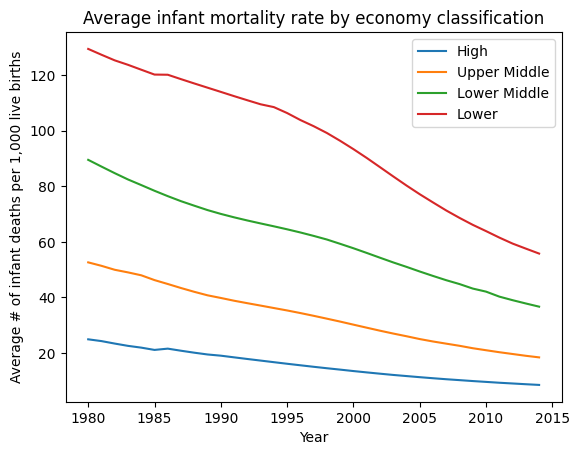

In [29]:
# Plot
ax = infancy_mortality_income.plot(x='Year', y=['high', 'upper_middle', 'lower_middle', 'lower'], kind='line')

# Legend
plt.legend(['High', 'Upper Middle', 'Lower Middle', 'Lower'])

# Titles
ax.set_title('Average infant mortality rate by economy classification')
ax.set_xlabel('Year')
ax.set_ylabel('Average # of infant deaths per 1,000 live births')

# Show
plt.show()

As we can see, the trend is quite clear across the 4 income levels—a higher income level corresponds with a lower infant mortality rate. This supports our initial hypothesis about this health indicator.


### Immunization, BCG (% of one-year-old children)

We now explore the data, specifically "Immunization, BCG (% of one-year-old children)", based on how it varies by the country's income level.

In [30]:
# Filter the data to include only rows with Indicator Code = SH.IMM.IDPT
infancy_immunization_income = avg_columns_by_level[avg_columns_by_level['Indicator Code'] == 'SH.IMM.IDPT']

# Transpose
infancy_immunization_income = infancy_immunization_income.T.reset_index()

# Rename columns
infancy_immunization_income.columns = ['Year', 'high', 'lower', 'lower_middle', 'upper_middle']

# Drop rows
infancy_immunization_income = infancy_immunization_income.drop(index=[0, 1, 2])

# Convert column type
infancy_immunization_income['Year'] = infancy_immunization_income['Year'].astype(int)

# Show
infancy_immunization_income

,Year,high,lower,lower_middle,upper_middle
3,1980,76.182041,49.062406,50.822958,60.785185
4,1981,78.088636,35.913149,46.099509,61.86263
5,1982,79.401989,34.148232,46.171197,65.352763
6,1983,80.393585,33.011762,43.800502,61.88085
7,1984,81.443976,33.450919,41.874945,66.40861
8,1985,82.280319,30.729672,47.253457,68.836798
9,1986,85.530638,38.037653,52.071799,71.521078
10,1987,85.98834,43.137317,56.225845,74.428737
11,1988,86.584867,46.261881,62.436254,78.403751
12,1989,87.630335,52.700032,67.989015,81.562813


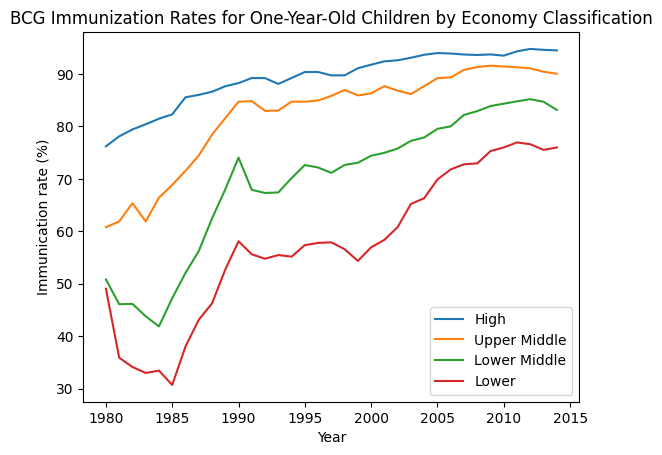

In [31]:
# Plot
ax = infancy_immunization_income.plot(x='Year', y=['high', 'upper_middle', 'lower_middle', 'lower'], kind='line')

# Legend
plt.legend(['High', 'Upper Middle', 'Lower Middle', 'Lower'])

# Titles
ax.set_title('BCG Immunization Rates for One-Year-Old Children by Economy Classification')
ax.set_xlabel('Year')
ax.set_ylabel('Immunication rate (%)')

# Show
plt.show()

Once again, the data supports our hypothesis. As income level increases, the immunization rate increases.

It appears that a country's economic level corresponds nicely with at least a subset of the infant health indicators we have selected.

## 2.3: Select Youth indicators segmented by economy classifcation

### Prevalence of anemia among children (% of children under 5)

We now explore the data, specifically "Prevalence of anemia among children (% of children under 5)", based on how it varies by the country's income level.

In [32]:
# Filter the data to include only rows with Indicator Code = SH.ANM.CHLD.ZS
infancy_anemia_income = avg_columns_by_level[avg_columns_by_level['Indicator Code'] == 'SH.ANM.CHLD.ZS']

# Transpose
infancy_anemia_income = infancy_anemia_income.T.reset_index()

# Rename columns
infancy_anemia_income.columns = ['Year', 'high', 'lower', 'lower_middle', 'upper_middle']

# Drop rows
infancy_anemia_income = infancy_anemia_income.drop(index=[0, 1, 2])

# Convert column type
infancy_anemia_income['Year'] = infancy_anemia_income['Year'].astype(int)

# Show
infancy_anemia_income

,Year,high,lower,lower_middle,upper_middle
3,1980,23.629493,69.954082,51.318436,36.634132
4,1981,23.629493,69.954082,51.318436,36.634132
5,1982,23.629493,69.954082,51.318436,36.634132
6,1983,23.629493,69.954082,51.318436,36.634132
7,1984,23.629493,69.954082,51.318436,36.634132
8,1985,23.629493,69.954082,51.318436,36.634132
9,1986,23.629493,69.954082,51.318436,36.634132
10,1987,23.629493,69.954082,51.318436,36.634132
11,1988,23.629493,69.954082,51.318436,36.634132
12,1989,23.629493,69.954082,51.318436,36.634132


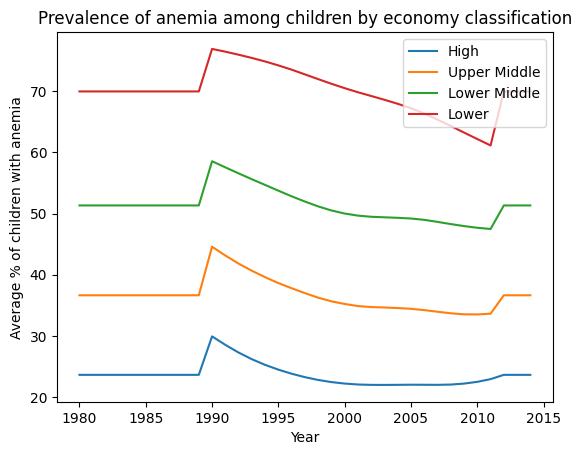

In [33]:
# Plot
ax = infancy_anemia_income.plot(x='Year', y=['high', 'upper_middle', 'lower_middle', 'lower'], kind='line')

# Legend
plt.legend(['High', 'Upper Middle', 'Lower Middle', 'Lower'])

# Titles
ax.set_title('Prevalence of anemia among children by economy classification')
ax.set_xlabel('Year')
ax.set_ylabel('Average % of children with anemia')

# Show
plt.show()

The irregular straight-line pattern shown from 1980 to around 1989 can be explained by the mean-based imputation we completed early. Regardless, the trend corresponds with our hypothesis—that negative health indicators correspond inversely with income level. 

### Prevalence of overweight (% of children under 5)

We now explore the data, specifically "Prevalence of overweight (% of children under 5)", based on how it varies by the country's income level.

In [34]:
# Filter the data to include only rows with Indicator Code = SH.STA.OWGH.ZS
youth_overweight_income = avg_columns_by_level[avg_columns_by_level['Indicator Code'] == 'SH.STA.OWGH.ZS']

# Transpose
youth_overweight_income = youth_overweight_income.T.reset_index()

# Rename columns
youth_overweight_income.columns = ['Year', 'high', 'lower', 'lower_middle', 'upper_middle']

# Drop rows
youth_overweight_income = youth_overweight_income.drop(index=[0, 1, 2])

# Convert column type
youth_overweight_income['Year'] = youth_overweight_income['Year'].astype(int)

# Show
youth_overweight_income

,Year,high,lower,lower_middle,upper_middle
3,1980,6.1655,4.815169,7.256735,8.896585
4,1981,5.986056,4.815169,7.256735,8.875057
5,1982,6.133379,4.815169,7.222272,8.829224
6,1983,6.1305,4.815169,7.180194,8.896585
7,1984,6.1305,4.830554,7.256735,8.896585
8,1985,6.1305,4.815169,7.256735,8.920543
9,1986,6.266722,4.815169,7.290999,8.840543
10,1987,6.235045,4.712605,7.013571,8.793981
11,1988,6.057167,4.796707,6.938437,8.856585
12,1989,6.1305,4.815169,7.236396,8.933668


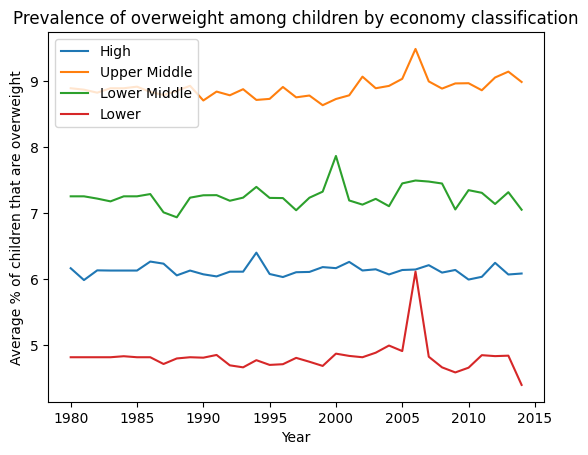

In [35]:
# Plot
ax = youth_overweight_income.plot(x='Year', y=['high', 'upper_middle', 'lower_middle', 'lower'], kind='line')

# Legend
plt.legend(['High', 'Upper Middle', 'Lower Middle', 'Lower'], loc='upper left')

# Titles
ax.set_title('Prevalence of overweight among children by economy classification')
ax.set_xlabel('Year')
ax.set_ylabel('Average % of children that are overweight')

# Show
plt.show()

The lineplot does not correspond exactly with our initial hypothesis. It appears that the weight of children does not directly correspond to income level. This makes sense, however; a lack of overweight children can be due to either a lack of food (which could be found in low income countries) or healthy countries (which could be found in more developed, higher income countries).

Once again, it appears that a country's economic level corresponds nicely with at least a subset of the youth health indicators we have selected.

## 2.4: Select Adulthood indicators segmented by economy classifcation

### Mortality rate, adult, male (per 1,000 male adults)

We now explore the data, specifically "Mortality rate, adult, male (per 1,000 male adults)", based on how it varies by the country's income level.

In [36]:
# Filter the data to include only rows with Indicator Code = SP.DYN.AMRT.MA
adult_mortality_income = avg_columns_by_level[avg_columns_by_level['Indicator Code'] == 'SP.DYN.AMRT.MA']

# Transpose
adult_mortality_income = adult_mortality_income.T.reset_index()

# Rename columns
adult_mortality_income.columns = ['Year', 'high', 'lower', 'lower_middle', 'upper_middle']

# Drop rows
adult_mortality_income = adult_mortality_income.drop(index=[0, 1, 2])

# Convert column type
adult_mortality_income['Year'] = adult_mortality_income['Year'].astype(int)

# Show
adult_mortality_income

,Year,high,lower,lower_middle,upper_middle
3,1980,210.893771,394.110637,326.354217,255.112008
4,1981,207.736784,389.7402,322.369076,253.959022
5,1982,204.253139,385.373167,318.334857,252.772795
6,1983,204.213911,383.306602,315.410644,249.252006
7,1984,201.843413,381.248637,312.630955,246.301852
8,1985,198.569835,379.20043,309.450709,241.426116
9,1986,194.524378,377.159943,306.046442,235.423668
10,1987,192.335655,375.131191,303.285435,231.860649
11,1988,189.927515,378.305031,302.302144,231.316914
12,1989,188.762813,381.487329,301.588754,231.634088


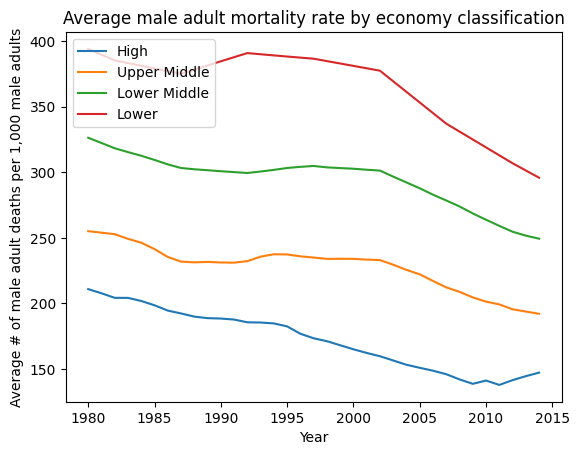

In [37]:
# Plot
ax = adult_mortality_income.plot(x='Year', y=['high', 'upper_middle', 'lower_middle', 'lower'], kind='line')

# Legend
plt.legend(['High', 'Upper Middle', 'Lower Middle', 'Lower'], loc='upper left')

# Titles
ax.set_title('Average male adult mortality rate by economy classification')
ax.set_xlabel('Year')
ax.set_ylabel('Average # of male adult deaths per 1,000 male adults')

# Show
plt.show()

Once again, the data corresponds with our hypothesis about the relationship between income level and negative health indicators. 

### Prevalence of anemia among pregnant women (%)

We now explore the data, specifically "Prevalence of anemia among pregnant women (%)", based on how it varies by the country's income level.

In [38]:
# Filter the data to include only rows with Indicator Code = SH.PRG.ANEM
adult_anemia_income = avg_columns_by_level[avg_columns_by_level['Indicator Code'] == 'SH.PRG.ANEM']

# Transpose
adult_anemia_income = adult_anemia_income.T.reset_index()

# Rename columns
adult_anemia_income.columns = ['Year', 'high', 'lower', 'lower_middle', 'upper_middle']

# Drop rows
adult_anemia_income = adult_anemia_income.drop(index=[0, 1, 2])

# Convert column type
adult_anemia_income['Year'] = adult_anemia_income['Year'].astype(int)

# Show
adult_anemia_income

,Year,high,lower,lower_middle,upper_middle
3,1980,27.813787,50.323511,41.452539,33.857027
4,1981,27.813787,50.323511,41.452539,33.857027
5,1982,27.813787,50.323511,41.452539,33.857027
6,1983,27.813787,50.323511,41.452539,33.857027
7,1984,27.813787,50.323511,41.452539,33.857027
8,1985,27.813787,50.323511,41.452539,33.857027
9,1986,27.813787,50.323511,41.452539,33.857027
10,1987,27.813787,50.323511,41.452539,33.857027
11,1988,27.813787,50.323511,41.452539,33.857027
12,1989,27.813787,50.323511,41.452539,33.857027


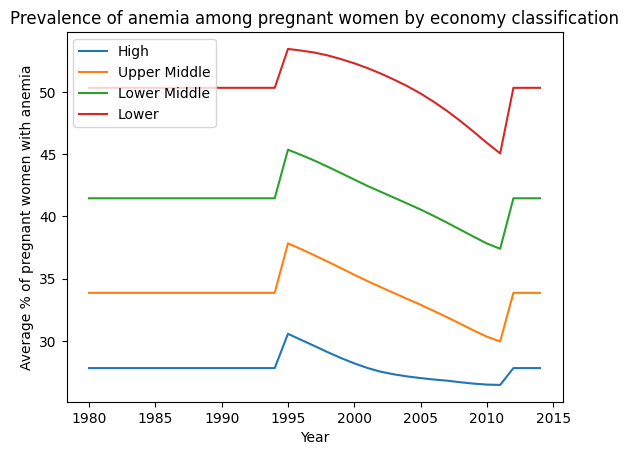

In [39]:
# Plot
ax = adult_anemia_income.plot(x='Year', y=['high', 'upper_middle', 'lower_middle', 'lower'], kind='line')

# Legend
plt.legend(['High', 'Upper Middle', 'Lower Middle', 'Lower'], loc='upper left')

# Titles
ax.set_title('Prevalence of anemia among pregnant women by economy classification')
ax.set_xlabel('Year')
ax.set_ylabel('Average % of pregnant women with anemia')

# Show
plt.show()

The irregularity for the early years can once again be explained by the mean-based imputation we completed. Otherwise, the trends follow our hypotheses from earlier.

Finally, it appears that a country's economic level corresponds nicely with at least a subset of the adult health indicators we have selected.

# Part 3: Neural Network Model

In this section, we build a neural network model that predicts how well the predictors match the indicators for different age segments.

## 3.1: Instantiate the Neural Network

We have a function below that uses plotly to creating a training and validation loss curve.

In [40]:
class Net(nn.Module):
    def __init__(self, input_size, output_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, output_size)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## 3.2: Training the Neural Network Model

**Creates Arrays from Data based on Indicators**

In [41]:
def interpolate_and_clean(data):
    # Drop columns that will not be used as data
    data = data.drop(columns=['Country Name', 'Country Code'])
    # Drop rows where all of the numerical data is missing
    df = data.dropna(subset=data.columns.difference(['Indicator Name', 'Indicator Code']), axis = 0, how = 'all')
    # Fill missing data with the mean based imputation
    df = df.apply(lambda row: row.fillna(row[data.columns.difference(['Indicator Name', 'Indicator Code'])].mean()), axis=1).dropna()
    return df

In [42]:
def preprocess_data(data, code = 'all'):
    # Initialize empty lists to store processed data
    X1 = []
    y1 = []
    y2 = []
    y3 = []

    # Group the input data by country
    for country, data in data.groupby('Country Name'):
        # If the code is 'all' or matches the current country, preprocess the data
        if code == 'all' or code == country:
            df = interpolate_and_clean(data)

            # Extract rows data for selected predictors and age-wise indicators
            X = df.loc[df['Indicator Name'].isin(predictors)].drop(columns=['Indicator Name', 'Indicator Code']).transpose().to_numpy()
            infancy_y = df.loc[df['Indicator Name'].isin(infancy_indicators)].drop(columns=['Indicator Name', 'Indicator Code']).transpose().to_numpy()
            youth_y = df.loc[df['Indicator Name'].isin(youth_indicators)].drop(columns=['Indicator Name', 'Indicator Code']).transpose().to_numpy()
            adult_y = df.loc[df['Indicator Name'].isin(adult_indicators)].drop(columns=['Indicator Name', 'Indicator Code']).transpose().to_numpy()

            # Check if there is sufficient data to add onto our complete dataset
            add_on = True
            for ary, real in zip([X, infancy_y, youth_y, adult_y], [25, 7, 6, 8]):
                if ary.shape[1] != real:
                    add_on = False
              
            # Append to the complete dataset
            if add_on or code != 'all':
                X1.extend(X)
                y1.extend(infancy_y)
                y2.extend(youth_y)
                y3.extend(adult_y)

    # Stack the lists of processed data into numpy arrays and return them
    return np.vstack(X1), np.vstack(y1), np.vstack(y2), np.vstack(y3)

In [43]:
def scale_and_split(X, y):
    # Standardize the training data features
    scaler = StandardScaler().fit(X)
    X = scaler.transform(X)

    # Create PyTorch tensors for the standardized features and target values
    X_tensor = torch.tensor(X, dtype=torch.float)
    y_tensor = torch.tensor(y, dtype=torch.float)

    # Split the data into training and validation sets
    return train_test_split(X_tensor, y_tensor, test_size=0.3)

In [44]:
def train(X, y):
    # Split the data into training and validation sets and create the NN
    X_train, X_val, y_train, y_val = scale_and_split(X, y)
    net = Net(X_train.shape[1], y_train.shape[1])

    # Set the criterion for the loss function to be mean squared error (MSE) with Adam optimizr
    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=0.01)

    num_epochs = 1000
    training_loss = []
    val_loss = []

    for epoch in range(num_epochs):
        # Zero the gradients
        optimizer.zero_grad()

        # Compute the outputs and loss for the training data
        outputs = net(X_train)
        loss = criterion(outputs, y_train)

        # Backpropagate the loss and update the network parameters
        loss.backward()
        optimizer.step()

        # Compute the loss for the validation data
        pred = net(X_val)
        v_l = criterion(pred, y_val)

        # Store the training and validation loss for this epoch
        training_loss.append((epoch, loss.item()))
        val_loss.append((epoch, v_l.item()))

    # Print the final training and validation loss
    print("Training Loss", training_loss[-1][1])
    print("Validation Loss", val_loss[-1][1])

    # Create a plot of the training and validation loss as a function of the epoch number
    plot_loss(training_loss, val_loss)

## 3.3: Graphing the Results

Below are two wrapper functions for the functionality to display the graphs.

In [45]:
def plot_loss(training_loss, val_loss):
    fig = make_subplots(rows=1, cols=1, shared_xaxes=True)

    # Add the training loss line
    fig.add_trace(go.Scatter(x=[step for (step, _) in training_loss], 
                            y=[loss for (_, loss) in training_loss], 
                            mode='lines', name='Training Loss'))
    
    # Add the validation loss line
    fig.add_trace(go.Scatter(x=[step for (step, _) in val_loss], 
                            y=[loss for (_, loss) in val_loss], 
                            mode='lines', name='Validation Loss'))

    # Add axis titles and main title
    fig.update_layout(title='Training and Validation Loss',
                      xaxis_title='Epoch',
                      yaxis_title='Loss')

    fig.show()

In [46]:
def display(country):
    # Get the data for a specific country
    X, infancy_y, youth_y, adult_y = preprocess_data(data, country)

    # Print final losses and training/validation curves for each stage
    print("Infancy")
    train(X, infancy_y)
    print("Youth")
    train(X, youth_y)
    print("Adulthood")
    train(X, adult_y)

**Results for Various Regions**

Below are the results for analysis on the United States, European Union, and with all Countries conglomerated into one dataset.

With the United States, we can see strong convergence in the training, with validation loss generally being minimized in the youth data segment, and performing worst in adulthood. Thus, we have that in the United States, health indicators are easiest to predict in younger people, and become more difficult with age.

In [47]:
display('United States')

Infancy
Training Loss 0.1121203601360321
Validation Loss 43.6057014465332


Youth
Training Loss 0.02016899734735489
Validation Loss 1.0373460054397583


Adulthood
Training Loss 0.3628668189048767
Validation Loss 378.6209411621094


With the EU, we can see extremely similar results to the United States. In the youth, we have the strongest performance of our model on the youth age segment and still the worst performance on the adult segment.  

In [48]:
display('European Union')

Infancy
Training Loss 0.8005011677742004
Validation Loss 68.0095443725586


Youth
Training Loss 0.026256293058395386
Validation Loss 1.5740933418273926


Adulthood
Training Loss 3.684570789337158
Validation Loss 102.03715515136719


Now, we can see that when we treat every country as an independent data source and conglomerate them all together, then we have very poor convergence of the neural network. As such, it is necessary to segment by each country. 

In [49]:
display('all')

Infancy
Training Loss 54.973445892333984
Validation Loss 64.07893371582031


Youth
Training Loss 4004498432.0
Validation Loss 4746886656.0


Adulthood
Training Loss 6202361856.0
Validation Loss 4171218688.0


## 3.4: Analysis of Results

Our overall conclusion through this neural network model is that our  features representing different regions have a strong correlation with health indicators amongst the youth of countries. In general, these predictors become less representative of health as aging occurs.

Furthermore, we can see that this predictive nature is only highly prevalent when segmenting by country, and when the data is combined the convergence is much weaker. Tentatively, this is because in different regions of the world different underlying factors explain each indicator, so features would need different weights and an overarching neural network will perform much more poorly. 

Overall, we see promising results in the prediction of health trends from a variety of economic and social indicators in our dataset.

# Part 4: Linear Regression Model

In this section, we build a linear regression model to extract feature importance and analyze exactly which social and economic predictors correlate most strongly with health outcomes. 

## 4.1: Processing Data

The following method splits the indicators and splits them into their various predictors/indicators per age group as well as the predictor columns

In [50]:
def segment_by_age(df):
    X = df.loc[df['Indicator Name'].isin(predictors)].drop(columns=['Indicator Name', 'Indicator Code']).transpose().to_numpy()
    col_names = list(df.loc[df['Indicator Name'].isin(predictors)]['Indicator Name'].unique())

    infancy_y = df.loc[df['Indicator Name'].isin(infancy_indicators)].drop(columns=['Indicator Name', 'Indicator Code']).transpose().to_numpy()
    youth_y = df.loc[df['Indicator Name'].isin(youth_indicators)].drop(columns=['Indicator Name', 'Indicator Code']).transpose().to_numpy()
    adult_y = df.loc[df['Indicator Name'].isin(adult_indicators)].drop(columns=['Indicator Name', 'Indicator Code']).transpose().to_numpy()
    return X, col_names,infancy_y, youth_y, adult_y

In [51]:
X, col_names, infancy_y, youth_y, adult_y = segment_by_age(df)

## 4.2: Linear Regression Model Implementation

The following model trains a linear regression model using a 70/30 split of training/testing data and plots the values across the linear regression model as well as the importance of each feature, sorted, in the model as well as the R-squared and MSE values. 

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt
def trainLinear(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Train the model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Evaluate the model on test set
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    
    # Plot the results
    fig, ax = plt.subplots(figsize=(10, 5))
    
    # Plot scatter plot
    ax.scatter(y_test, y_pred)
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    ax.set_title('Predicted vs Measured')
    
    # Plot feature importance
    coef = model.coef_
    feature_names = range(X.shape[1])
    feature_importance = {feature_names[i]: coef[0][i] for i in range(X.shape[1])}
    
    # Print feature importance values in descending order
    print("Feature importance:")
    for feature, importance in sorted(feature_importance.items(), key=lambda x: x[1], reverse=True):
        print(f"Feature {col_names[feature]}: {importance}")
    r2 = model.score(X_test, y_test)
    print(f"R-squared value: {r2}")
 
    
    print("Mean Squared Value - " + str(mse))

## 4.3: Model Training

Run the model on the infancy data and output the results

Feature importance:
Feature Immunization, DPT (% of children ages 12-23 months): 1.0000000000000018
Feature People practicing open defecation, rural (% of rural population): 2.4924019011857146e-12
Feature Improved water source (% of population with access): 2.106225558464722e-12
Feature Improved sanitation facilities, urban (% of urban population with access): 1.4260278810923394e-12
Feature Improved sanitation facilities (% of population with access): 3.646125327155572e-13
Feature Fertility rate, total (births per woman): 1.5462726846000138e-13
Feature Health expenditure, private (% of GDP): 6.195695830314546e-14
Feature Literacy rate, adult total (% of people ages 15 and above): 2.765470751086416e-14
Feature Out-of-pocket health expenditure (% of private expenditure on health): 1.471967079474945e-14
Feature Literacy rate, youth total (% of people ages 15-24): 8.898704798588663e-15
Feature Adolescent fertility rate (births per 1,000 women ages 15-19): 6.661338147750939e-16
Feature Risk

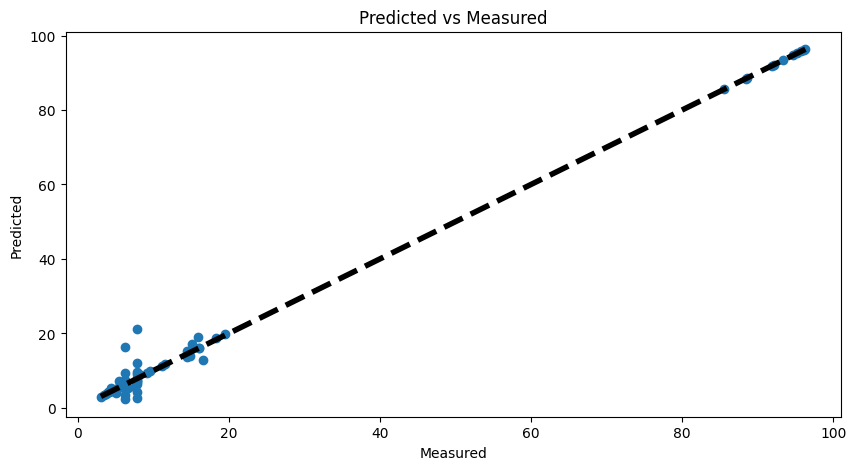

In [53]:
trainLinear(X, infancy_y)

Train the model on the predictors and youth indicators

Feature importance:
Feature People practicing open defecation, urban (% of urban population): 979.5850286088232
Feature Improved water source, urban (% of urban population with access): 66.74848839088938
Feature Improved water source, rural (% of rural population with access): 45.92521391640934
Feature Health expenditure, private (% of GDP): 8.762853670012333
Feature Improved sanitation facilities (% of population with access): 6.649740300379725
Feature Birth rate, crude (per 1,000 people): 1.217714781881729
Feature Population growth (annual %): 0.9567827778506717
Feature Improved sanitation facilities, rural (% of rural population with access): 0.849169170659669
Feature Adolescent fertility rate (births per 1,000 women ages 15-19): 0.813736915301368
Feature Life expectancy at birth, total (years): 0.4489747962516669
Feature Immunization, Hib3 (% of children ages 12-23 months): 0.37832216100058946
Feature Out-of-pocket health expenditure (% of private expenditure on health): 0.29807565

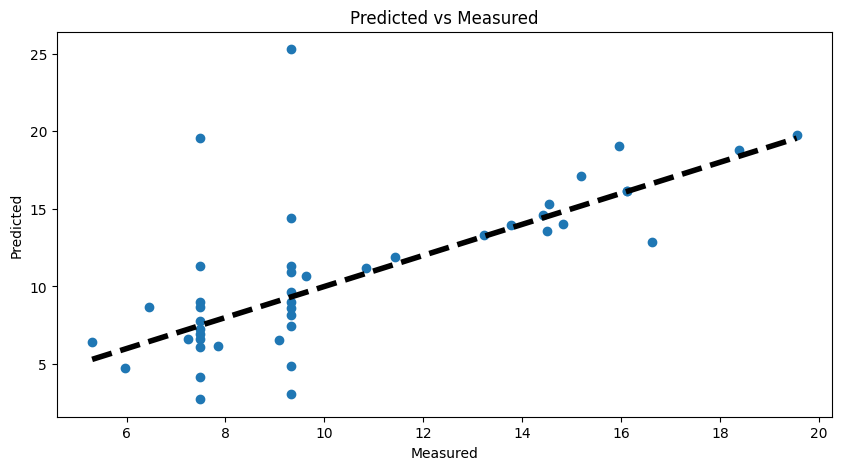

In [54]:
trainLinear(X, youth_y)

Train the model on the predictors and the adult indicators

Feature importance:
Feature Improved water source (% of population with access): 47.590235830160296
Feature People practicing open defecation, rural (% of rural population): 30.285961183928006
Feature Improved sanitation facilities (% of population with access): 20.862671416355486
Feature Improved sanitation facilities, urban (% of urban population with access): 4.191799930157312
Feature Fertility rate, total (births per woman): 3.5866988995152123
Feature Birth rate, crude (per 1,000 people): 0.8576222020152511
Feature Life expectancy at birth, total (years): 0.6082226592243513
Feature Immunization, HepB3 (% of one-year-old children): 0.13586763210690278
Feature Immunization, Pol3 (% of one-year-old children): 0.02263816489405879
Feature Risk of catastrophic expenditure for surgical care (% of people at risk): 8.567453252397976e-20
Feature Risk of impoverishing expenditure for surgical care (% of people at risk): 0.0
Feature Immunization, measles (% of children ages 12-23 months): -0.0

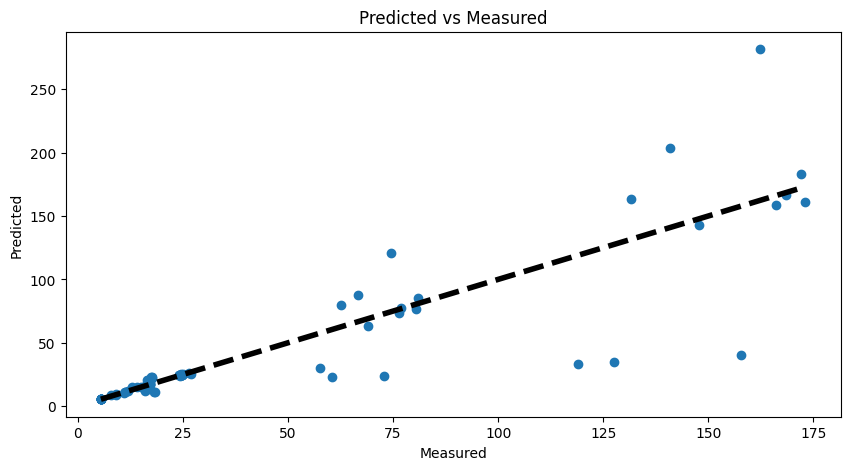

In [55]:
trainLinear(X, adult_y)

## 4.4: Analysis of Results

The linear regression results on Infant, Youth, and Adult are shown below.

For Infant, the most important feature is Immunization, DPT (% of children ages 12-23 months) with a value of 1.0. The rest of the features have values that are many orders of magnitude smaller, indicating their relative unimportance. The R-squared value is negative, which is not ideal and may suggest poor model fit.

For Youth, the most important feature is People practicing open defecation, urban (% of urban population) with a value of 979.585. Other important features include Improved water source, urban (% of urban population with access), Improved water source, rural (% of rural population with access), and Health expenditure, private (% of GDP). The least important features are Literacy rate, adult total (% of people ages 15 and above), Fertility rate, total (births per woman), and Literacy rate, youth total (% of people ages 15-24). The risk of impoverishing expenditure for surgical care has no importance as it has a zero value.

Overall, the results indicate that there are significant differences in the importance of features between Infant and Youth, and that some features are more important for predicting Youth outcomes than others. However, the negative R-squared value for Infant suggests that the model may not fit the data well, and additional analysis is needed to determine the validity and reliability of the results.

# Part 5: Conclusion

In conclusion, our study aims to explore the relationship between economic and social predictors and health indicators by age. Through the use of various predictive models and regression analysis, we were able to identify which predictors were most strongly correlated with health outcomes for different age segments of the population. Our results indicate that there is a strong correlation between predictors and health indicators amongst youth, but this correlation weakens as individuals age. Furthermore, our analysis suggests that regional differences in underlying factors can impact the accuracy of predictions, and that an overarching neural network may perform poorly as a result. Overall, our study demonstrates promising results in the prediction of health trends from economic and social indicators. However, further analysis is needed to determine the validity and reliability of our findings, particularly with regards to the negative R-squared value for infant outcomes.

Based on the limitations of this study, some potential improvements could be made in future research. For instance, the study could benefit from the use of a larger and more diverse dataset to improve the generalizability of the results. Additionally, incorporating more features that capture additional dimensions of economic and social welfare could provide a more comprehensive understanding of the predictors of health indicators. Finally, the study could explore different predictive models beyond linear regression and neural networks to determine the most effective approach for predicting health outcomes by age group and region.